In [1]:
from quippy import descriptors
import ase
import ase.build

# Descriptors

In this tutorial, we will:

1. Load a small dataset of **DFT-calculated CH structures**.
2. Compute **SOAP descriptors** to represent atomic environments.
3. Train a **GAP** model to predict energies.
4. Wrap the model in an **ASE calculator**.
5. Run a short **molecular dynamics (MD)** simulation with our ML potential.

This will give you a full **training → usage** pipeline for a machine-learning interatomic potential.

---
### Requirements:
- `ase`
- `quippy`
- `matplotlib`
- `numpy`

*(Install with `pip install ase dscribe scikit-learn matplotlib` if needed.)*

# Local GPR with SOAP Descriptors

In this notebook, we build a Gaussian Process Regression (GPR) model to predict atomic energies from SOAP (Smooth Overlap of Atomic Positions) descriptors.
We assume a local energy model:


$$E = \sum_{i=1}^{N} E_i(\mathbf{p}_i)$$

Where:

- $E_i$ is the local energy of atom _i_,

- $\mathbf{p}_i$ is the SOAP vector of atom _i_
  
$$E_{\text{total}}^{\text{test}} = \sum_{i \in \text{test}} \sum_{j \in \text{train}} \alpha_j \cdot k(\mathbf{p}_i, \mathbf{p}_j)$$
   
- $k(\mathbf{p}_i, \mathbf{p}_j)$ is the SOAP kernel
- $\alpha_j$ is the coefficient from GPR training


### We use QUIP to compute SOAP vectors and NumPy for GPR training

#### Imports & Parameters

In [2]:
from quippy.descriptors import Descriptor #
from ase.io import read, write
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import random
#import nglview as nv

In [73]:
# Descriptor string (modify for your system)
soap_str = "soap cutoff=3 l_max=4 n_max=4 atom_sigma=0.5 n_Z=1 Z1=6"

# SOAP kernel exponent and GPR noise
zeta = 4
sigma_n = 1e-1

In [4]:
# Initialize SOAP descriptor
soap_descriptor = Descriptor(soap_str)

#### Load the structures using ASE

In [7]:
db=read('a_C_db.xyz', ':')

In [8]:
print("The database has:", len(db), " carbon structures")

The database has: 450  carbon structures


<img src="bulk_amo_2.png" width="300"/> <img src="bulk_amo_4.png" width="300"/> <img src="bulk_cryst_1.png" width="300"/> <img src="bulk_cryst_4.png" width="300"/>

In [84]:
def split_xyz(input_file, test_size=0.2, seed=42):
    
    # Automatically detect the input file path if not provided
    if not os.path.exists(input_file):
        raise FileNotFoundError(f"Input file '{input_file}' not found in the current directory.")

    # Load the structures
    structures = read(input_file, index=":")
    print(f"Loaded {len(structures)} structures from {input_file}")

    # Randomly shuffle the structures
    random.seed(seed)
    random.shuffle(structures)

    # Split into train and test sets
    split_idx = int(len(structures) * (1 - test_size))
    train_structures = structures[:split_idx]
    test_structures = structures[split_idx:]

    # Derive output file names
    input_name = os.path.basename(input_file).split('.')[0]  # Remove file extension
    train_file = os.path.join(f"{input_name}_train.xyz")
    test_file = os.path.join(f"{input_name}_test.xyz")

    # Write to output files
    write(train_file, train_structures)
    write(test_file, test_structures)

    print(f"Split complete: {len(train_structures)} training structures, {len(test_structures)} test structures.")
    print(f"Saved to:\n  - Training set: {train_file}\n  - Test set: {test_file}")



In [10]:
split_xyz('a_C_db.xyz', 0.75)

Loaded 450 structures from a_C_db.xyz
Split complete: 112 training structures, 338 test structures.
Saved to:
  - Training set: a_C_db_train.xyz
  - Test set: a_C_db_test.xyz


In [11]:
structures=read('a_C_db_train.xyz', ':')
print(f"Loaded {len(structures)} C structures.")

Loaded 112 C structures.


#### Compute SOAP descriptors and Energy per atom

#### We have a total energy of the structure. However, in order to learn our alphas, we need a decomposition of energy. What if we simply assume that energy can be devided by the number of atoms?
We assign per-atom energies by dividing the total energy of the structure equally among its atoms (simple assumption). Then each atom gets a SOAP descriptor. 



In [86]:
X_all=[] # List of arrays
e_all=[] # List of atomic energies

for atoms in structures:
    E_total = atoms.get_potential_energy()
    
    # Get per-atom SOAP (unnormalized)
    desc = soap_descriptor.calc(atoms, descriptor_only=True)
    X_atoms = desc['data']  # shape (N_atoms, D)
    
    # Assign per-atom energies equally (can be improved!)
    E_per_atom = E_total / len(atoms)
    e_atoms = np.full(len(atoms), E_per_atom)

    X_all.append(X_atoms)
    e_all.append(e_atoms)


In [100]:
print( "Number of SOAP vectors:", sum([x.shape[0] for x in X_all]))
print( "SOAP vector dimensions:", X_all[0].shape[1])

Number of SOAP vectors: 6982
SOAP vector dimensions: 51


In [101]:
# Stack all training data
X_train = np.vstack(X_all)   # shape (N_atoms_total, D)
e_train = np.concatenate(e_all) 
print("X_train shape:", X_train.shape)
print("e_train shape:", e_train.shape)

X_train shape: (6982, 51)
e_train shape: (6982,)


### Define SOAP Kernel and Train GPR

### We need to compute the SOAP kernel between each pair of training descriptors 

#### The resulting matrix K is a kernel matrix, where each entry K[i, j] measures similarity between atomic environments i and j.

In [102]:
def soap_kernel_matrix(X1, X2, zeta=4):
    K = np.dot(X1, X2.T)
    return K ** zeta


In [114]:
# Compute SOAP kernel
K = soap_kernel_matrix(X_train, X_train, zeta=zeta)

# Add regularization
K += sigma_n**2 * np.eye(len(X_train))



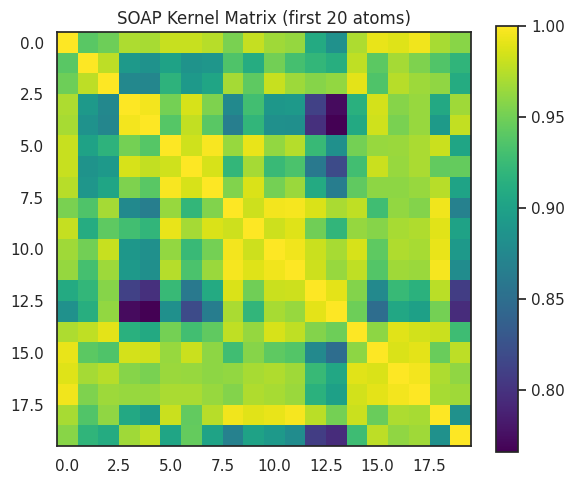

In [119]:
plt.figure(figsize=(6, 5))
plt.imshow(K[:20, :20], cmap='viridis')
plt.title("SOAP Kernel Matrix (first 20 atoms)")
plt.colorbar()
plt.tight_layout()
plt.show()


#### Instead of directly computing the inverse, we use Cholesky decomposition, which expresses the matrix as a product of a lower-triangular matrix L and its transpose L$^⊤$:

The fitting coefficients can be then obtained from matrix inversion:
$$
\alpha = (K + \sigma^2 I)^{-1} y
$$
- $\alpha$ is a weight vector (length = number of training data points)              
- $ K $ is a kernel matrix, with entries $ K_{ij} = k(\mathbf{x}_i, \mathbf{x}_j)$

- $\sigma^2$ is a regularization parameter
- $I$ - Identity matrix (same shape as \( K \))                                
- $ y$ - vector of training targets (e.g., atomic energies)

**Cholesky decomposition**:

$$
K + \sigma_n^2 I = L L^\top
$$

We then solve the system in two steps:

$$
L \mathbf{z} = \mathbf{y}
$$

Then:

$$
L^\top \boldsymbol{\alpha} = \mathbf{z}
$$


In [115]:
# alpha = (K + σ^2 I)^-1 y
L = np.linalg.cholesky(K) 
z = np.linalg.solve(L, e_train) # solve 

alpha = np.linalg.solve(L.T, z)  


In [123]:
print("Alpha is a vector of the same length of our energies:", alpha.shape)

Alpha is a vector of the same length of our energies: (6982,)


#### Visualize the Kernel Matrix

**Now that we have our $\alpha$s we can actually predict the energy of system based on our freshly fitted GPR model**

In [124]:
def predict_structure_energy(atoms, descriptor, X_train_all, alpha, zeta=4):
    """Predict total energy for a new structure using our model."""
    desc = descriptor.calc(atoms,properties=['energy'], descriptor_only=True)
    # print(desc['data'])
    X_test = desc['data']  
    
    # Kernel between test atoms and training atoms
    K_test = soap_kernel_matrix(X_test, X_train_all, zeta=zeta) 
    # Predict local energies and sum
    local_energies = np.dot(K_test, alpha) 
    total_energy = np.sum(local_energies)
    return total_energy

#### Predict on a New Structure

In [125]:
test_structures = read("a_C_db_test.xyz", index=":")

In [126]:
E_preds = [predict_structure_energy(a, soap_descriptor, X_train, alpha) for a in test_structures]
print(f"We predicted {len(E_preds)} energies of the test set using our GPR model")

We predicted 338 energies of the test set using our GPR model


In [127]:
E_pred_atom = [E_preds[i]/len(test_structures[i]) for i in range(0, len(test_structures))]

In [128]:
E_dft = [a.get_potential_energy()/len(a) for a in test_structures]

In [129]:
def rms_dict(x_ref, x_pred):
    """ Takes two datasets of the same shape and returns a dictionary containing RMS error data"""

    x_ref = np.array(x_ref)
    x_pred = np.array(x_pred)

    if np.shape(x_pred) != np.shape(x_ref):
        raise ValueError('WARNING: not matching shapes in rms')

    error_2 = (x_ref - x_pred) ** 2

    average = np.sqrt(np.average(error_2))
    std_ = np.sqrt(np.var(error_2))

    return {'rmse': average, 'std': std_}

In [132]:
from sklearn.metrics import r2_score, mean_squared_error
def parity_plot(y_true, y_pred, title="Parity Plot", xlabel="DFT Energy (eV)", ylabel="Predicted Energy (eV)"):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Compute metrics
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, s=10, alpha=0.7, label='Data')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2, label='Ideal')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.axis('equal')
    plt.legend()
    plt.text(0.05, 0.95, f"$R^2$ = {r2:.3f}\nRMSE = {rmse:.3f} eV",
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    plt.tight_layout()
    plt.show()

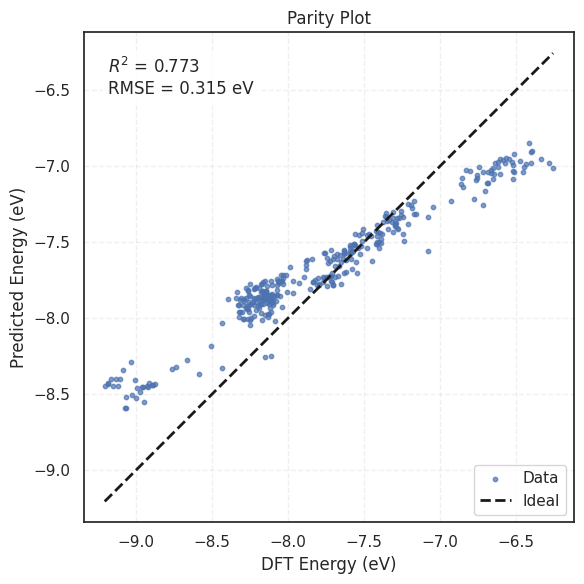

In [133]:
parity_plot(E_dft, E_pred)

In [82]:

# Convert to arrays
E_dft = np.array(E_dft)
E_pred = np.array(E_pred_atom)

# Compute absolute errors
errors = np.abs(E_dft - E_pred)

# Get index of the largest error (likely outlier)
outlier_index = np.argmax(errors)
print(f"Outlier index: {outlier_index}, error: {errors[outlier_index]:.6f} eV")

# Remove outlier from both lists
E_dft_clean = np.delete(E_dft, outlier_index)
E_pred_clean = np.delete(E_pred, outlier_index)

Outlier index: 235, error: 0.761743 eV


# Gaussian Approximation Potential (GAP)

## Sparse GPR with SOAP Descriptors using gap_fit and quippy

In GAP, we don't use all atomic environments to define the regression basis. Instead, we select a subset of atomic environments — **the sparse set** — to serve as representative points. But why Sparse GPR?

- **Computational Efficiency**

Full GPR scales like $O(N^3$) with N the number of data points.

By selecting $M≪NM≪N$ sparse points, GAP reduces the scaling to $O(NM^2)$, where M is the number of sparse environments.

This makes training and prediction feasible for thousands of atoms.

- **Avoiding Redundancy**

Many atomic environments are very similar — using all of them would just increase the model size without adding new information.

The sparse set acts like a dictionary of distinct environments.

- **Improving Generalization**

A sparse set made of diverse, informative environments allows the model to generalize better to unseen structures.

If chosen well (e.g., via CUR decomposition or clustering), the model:

- avoids overfitting,

- focuses on physically meaningful variations


In [14]:
!cat a_C_db_test.xyz a_C_db_train.xyz > db_full.xyz

In [136]:
from ase.io import read
from quippy.descriptors import Descriptor
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


all_structures = read("a_C_db_test.xyz", ":")

# Extract all atoms and calculate SOAP descriptors
soap_str = "soap cutoff=3.0 l_max=4 n_max=4 atom_sigma=0.5 n_species=1 species_Z=6"  
soap = Descriptor(soap_str)

soap_vectors = []
for at in all_structures:
    desc = soap.calc(at)
    soap_vectors.append(desc['data'])

soap_all = np.vstack(soap_vectors) 


In [137]:
# Simple random selection
n_sparse = 500
np.random.seed(42)
sparse_indices = np.random.choice(len(soap_all), size=n_sparse, replace=False)


In [138]:
pca = PCA(n_components=2)
soap_pca = pca.fit_transform(soap_all)

# Mark sparse points
sparse_pca = soap_pca[sparse_indices]


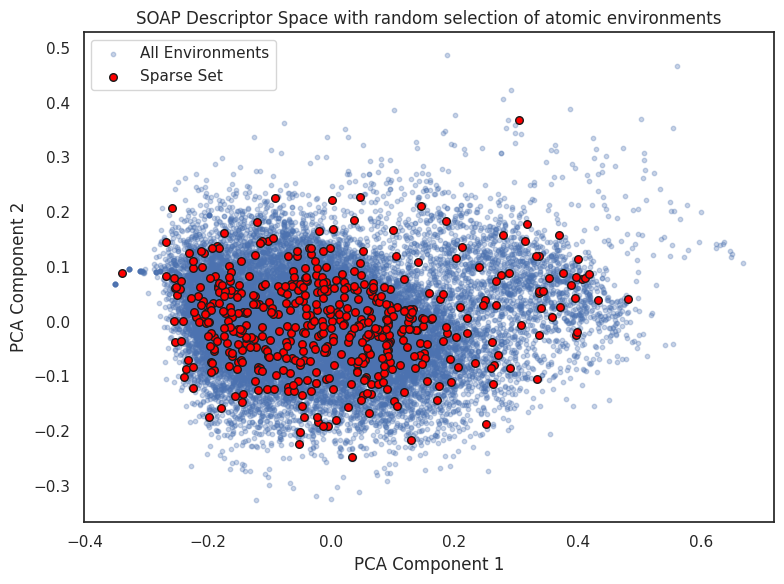

In [140]:
plt.figure(figsize=(8, 6))
plt.scatter(soap_pca[:, 0], soap_pca[:, 1], s=10, alpha=0.3, label='All Environments')
plt.scatter(sparse_pca[:, 0], sparse_pca[:, 1], s=30, c='red', label='Sparse Set', edgecolors='k')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("SOAP Descriptor Space with random selection of atomic environments")
plt.legend()
plt.tight_layout()
plt.show()


In [141]:
import numpy as np
from sklearn.utils.extmath import randomized_svd

# Center the SOAP matrix
X = soap_all - np.mean(soap_all, axis=0)

# Apply randomized SVD
U, S, VT = randomized_svd(X, n_components=20, random_state=42)

# Compute leverage scores: row importance
leverage_scores = np.sum(U**2, axis=1)  # shape: (N_atoms,)

# Select top-k rows with highest leverage scores
n_sparse = 500
sparse_indices = np.argsort(leverage_scores)[-n_sparse:]

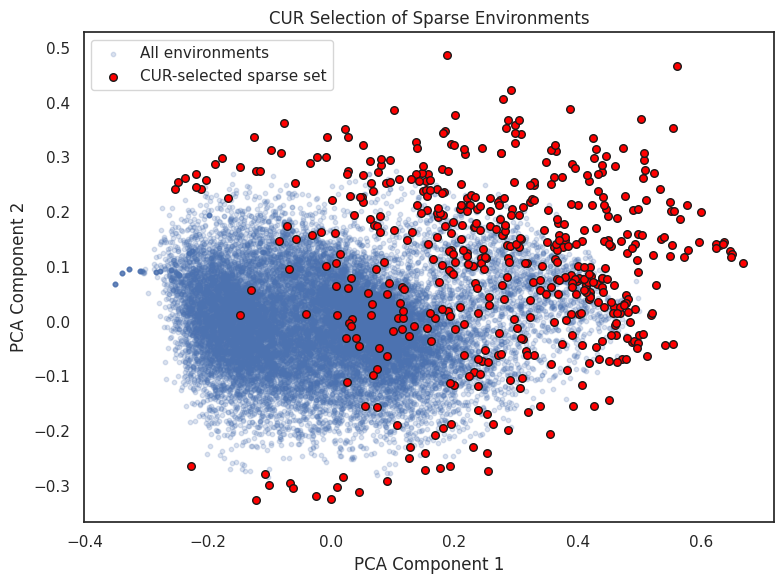

In [142]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Project to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
sparse_pca = X_pca[sparse_indices]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, alpha=0.2, label='All environments')
plt.scatter(sparse_pca[:, 0], sparse_pca[:, 1], c='red', s=30, edgecolors='k', label='CUR-selected sparse set')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("CUR Selection of Sparse Environments")
plt.legend()
plt.tight_layout()
plt.show()


In [143]:
import os
new_path = "/home/jovyan/shared/installations/bin"

# Append it to the PATH environment variable if it's not already there
if new_path not in os.environ["PATH"]:
    os.environ["PATH"] += os.pathsep + new_path

# Confirm the path was added
print(os.environ["PATH"])


/opt/conda/bin:/opt/conda/condabin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/home/jovyan/shared/installations/bin


In [1]:
! gap_fit \
  energy_parameter_name=free_energy \
  force_parameter_name=DUMMY \
  virial_parameter_name=DUMMY \
  at_file=a_C_db_test.xyz \
  gap="SOAP cutoff=3.0 l_max=4 n_max=4 atom_sigma=0.5 zeta=4 delta=1.0  n_species=1 species_Z=6\
  n_sparse=500 sparse_method=cur_points covariance_type=dot_product" \
  default_sigma={0.001 0.01 0.0 0.0} \
  e0=0.0 \
  do_copy_at_file=F \
  gp_file=C_GAP.xml

/bin/bash: line 1: gap_fit: command not found


In [3]:
import ase.io
from ase.optimize.bfgs import BFGS
from quippy.potential import Potential

In [2]:
atoms = ase.io.read("a_C_db_train.xyz", ':')

In [3]:
E_dft = []

In [ ]:
E_pred = []
calc = Potential(param_filename="gp_model_cur.xml")
atoms = ase.io.read("a_C_db_train.xyz", ':')
for atom in atoms:
    
    atom.calc = calc
    e_bulk = atom.get_potential_energy()/len(atom)
    E_pred.append(e_bulk)
    # print("Final energy:", e_bulk)


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

In [ ]:
E_dft = [a.get_potential_energy()/len(a) for a in atoms]

In [ ]:
import numpy as np


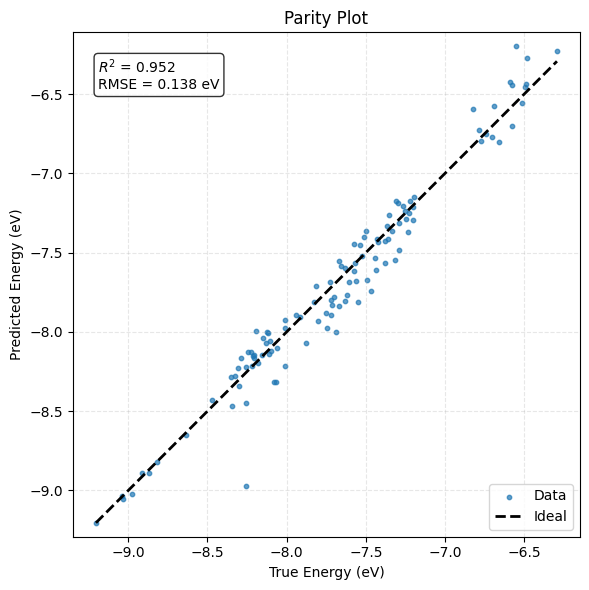

In [60]:
parity_plot(E_dft, E_pred)